# borderline-SMOTE SVM

1. Random Forest Classifier
2. Bagging Classifier
3. XGBoost
4. Gradient Boosting 
5. Extra Trees
6. Gaussian Naïve Bayes
7. CART
8. KNN
9. AdaBoost

In [5]:
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt
from time import time
import warnings
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import SVMSMOTE
import os

warnings.filterwarnings("ignore")

# Reading the file
df = pd.read_csv("all_three.csv")

# Dropping the first column because it is of no use  
df.drop(['Unnamed: 0'], axis=1, inplace=True)

# Segregating the features and labels 
Y = df[['label']]
X = df[['rec/sent','amount','size','weight','version','lock_time','is_coinbase',
        'has_witness','input_count','output_count','input_total_usd','output_total_usd',
        'fee_usd','fee_per_kb_usd','fee_per_kwu_usd','cdd_total']]

# Decimal point normalization (scaling each column by its max power of 10)
for col in X.columns: 
    max_val = X[col].max()
    q = len(str(abs(int(max_val)))) if max_val != 0 else 1
    X[col] = X[col] / (10**q)

# Splitting the data (60-40 split)
x_train, x_test, y_train, y_test = train_test_split(
    X, Y, test_size=0.2, random_state=42, stratify=Y
) 

# File to save resampled dataset
resampled_file = "x_y_train_resampled_SVMSMOTE.csv"

if not os.path.exists(resampled_file):
    print("Running SVMSMOTE... this may take a long time")
    Borderline_SMOTE_SVM = SVMSMOTE()
    x_res, y_res = Borderline_SMOTE_SVM.fit_resample(x_train, y_train)

    # Merge x and y to save in one CSV
    resampled_df = pd.concat([pd.DataFrame(x_res, columns=x_train.columns), 
                              pd.DataFrame(y_res, columns=["label"])], axis=1)
    resampled_df.to_csv(resampled_file, index=False)
    print(f"Resampled dataset saved to {resampled_file}")
else:
    print("Loading resampled dataset from CSV...")
    resampled_df = pd.read_csv(resampled_file)
    x_res = resampled_df.drop(columns=["label"])
    y_res = resampled_df[["label"]]

# Now x_res, y_res are your oversampled training sets
x_train, y_train = x_res, y_res


Running SVMSMOTE... this may take a long time
Resampled dataset saved to x_y_train_resampled_SVMSMOTE.csv


In [2]:
!pip install matplotlib

     ---------------------------------------- 0.0/111.9 kB ? eta -:--:--
     -------------- ------------------------ 41.0/111.9 kB 1.9 MB/s eta 0:00:01
     -------------------------------------- 111.9/111.9 kB 3.2 MB/s eta 0:00:00
   ---------------------------------------- 0.0/8.1 MB ? eta -:--:--
   -- ------------------------------------- 0.5/8.1 MB 16.3 MB/s eta 0:00:01
   ------ --------------------------------- 1.3/8.1 MB 20.5 MB/s eta 0:00:01
   ------------- -------------------------- 2.7/8.1 MB 24.8 MB/s eta 0:00:01
   -------------------- ------------------- 4.2/8.1 MB 29.6 MB/s eta 0:00:01
   ---------------------------- ----------- 5.8/8.1 MB 33.6 MB/s eta 0:00:01
   ------------------------------------- -- 7.5/8.1 MB 34.3 MB/s eta 0:00:01
   ---------------------------------------- 8.1/8.1 MB 32.5 MB/s eta 0:00:00
   ---------------------------------------- 0.0/226.6 kB ? eta -:--:--
   --------------------------------------- 226.6/226.6 kB 13.5 MB/s eta 0:00:00
   -----


[notice] A new release of pip is available: 24.0 -> 25.2
[notice] To update, run: python.exe -m pip install --upgrade pip


In [3]:
!pip install seaborn

   ---------------------------------------- 0.0/294.9 kB ? eta -:--:--
   - -------------------------------------- 10.2/294.9 kB ? eta -:--:--
   --------- ------------------------------ 71.7/294.9 kB 2.0 MB/s eta 0:00:01
   ------------------------------------ --- 266.2/294.9 kB 4.1 MB/s eta 0:00:01
   ---------------------------------------- 294.9/294.9 kB 3.6 MB/s eta 0:00:00



[notice] A new release of pip is available: 24.0 -> 25.2
[notice] To update, run: python.exe -m pip install --upgrade pip


In [6]:
# -----------------------------
# Required imports
# -----------------------------
from sklearn.metrics import (
    accuracy_score, confusion_matrix, classification_report,
    precision_score, recall_score, roc_auc_score, roc_curve, auc
)
from sklearn.preprocessing import label_binarize
import seaborn as sns
import matplotlib.pyplot as mplplt  # renamed to avoid overwriting issues
import psutil, os
import pandas as pd
import numpy as np
from time import time

# -----------------------------
# Full check_prediction function
# -----------------------------
def check_prediction(y_true, y_pred, start_time, model=None, x_test=None, x_train=None): 
    runtime_sec = time() - start_time
    
    # RAM usage
    process = psutil.Process(os.getpid())
    ram_used_mb = process.memory_info().rss / (1024 * 1024)
    
    # Base metrics
    acc = accuracy_score(y_true, y_pred)
    prec = precision_score(y_true, y_pred, average="weighted", zero_division=0)
    rec = recall_score(y_true, y_pred, average="weighted", zero_division=0)

    # ROC AUC
    roc_auc = None
    y_probs = None
    try:
        if model is not None and x_test is not None:
            if hasattr(model, "predict_proba"):
                y_probs = model.predict_proba(x_test)
            elif hasattr(model, "decision_function"):
                y_probs = model.decision_function(x_test)

        if y_probs is not None:
            classes = np.unique(y_true)
            y_true_bin = label_binarize(y_true, classes=classes)
            roc_auc = roc_auc_score(y_true_bin, y_probs, average="weighted", multi_class="ovr")
    except Exception as e:
        print(f"⚠ ROC AUC not available: {e}")

    # Confusion matrix
    cm = confusion_matrix(y_true, y_pred)

    # Print metrics
    print("\n===== Evaluation Results =====")
    print(f"runtime_sec: {runtime_sec:.4f}")
    print(f"ram_used_mb: {ram_used_mb:.4f}")
    print(f"accuracy: {acc:.4f}")
    print(f"precision: {prec:.4f}")
    print(f"recall: {rec:.4f}")
    print(f"roc_auc: {roc_auc:.4f}" if roc_auc else "roc_auc: N/A")
    print("confusion_matrix:\n", cm)
    print("================================\n")

    # Classification Report
    print("\nClassification Report:\n")
    print(classification_report(y_true, y_pred, zero_division=0))

    # -----------------------------
    # Confusion Matrix Heatmap
    # -----------------------------
    fig_cm, ax_cm = mplplt.subplots(figsize=(6,5))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", ax=ax_cm)
    ax_cm.set_title("Confusion Matrix")
    ax_cm.set_xlabel("Predicted")
    ax_cm.set_ylabel("True")
    mplplt.show()

    # -----------------------------
    # ROC Curve plotting
    # -----------------------------
    if y_probs is not None:
        try:
            if y_probs.ndim > 1 and y_probs.shape[1] > 1:  # multiclass
                n_classes = y_probs.shape[1]
                classes = np.unique(y_true)
                y_true_bin = label_binarize(y_true, classes=classes)

                fig_roc, ax_roc = mplplt.subplots(figsize=(7,6))
                for i in range(n_classes):
                    fpr, tpr, _ = roc_curve(y_true_bin[:, i], y_probs[:, i])
                    roc_auc_val = auc(fpr, tpr)
                    ax_roc.plot(fpr, tpr, label=f"Class {classes[i]} (AUC={roc_auc_val:.2f})")

                ax_roc.plot([0,1],[0,1],'k--')
                ax_roc.set_title("ROC Curves (Multiclass)")
                ax_roc.set_xlabel("False Positive Rate")
                ax_roc.set_ylabel("True Positive Rate")
                ax_roc.legend(loc="lower right")
                mplplt.show()
            else:  # binary
                if len(np.unique(y_true)) == 2:
                    fpr, tpr, _ = roc_curve(y_true, y_probs)
                    roc_auc_val = auc(fpr, tpr)
                    fig_roc, ax_roc = mplplt.subplots(figsize=(7,6))
                    ax_roc.plot(fpr, tpr, label=f"AUC={roc_auc_val:.2f}")
                    ax_roc.plot([0,1],[0,1],'k--')
                    ax_roc.set_title("ROC Curve (Binary)")
                    ax_roc.set_xlabel("False Positive Rate")
                    ax_roc.set_ylabel("True Positive Rate")
                    ax_roc.legend(loc="lower right")
                    mplplt.show()
        except Exception as e:
            print(f"⚠ ROC plotting failed: {e}")

    # -----------------------------
    # Feature Correlation Heatmap
    # -----------------------------
    if x_train is not None:
        corr = pd.DataFrame(x_train).corr()
        fig_corr, ax_corr = mplplt.subplots(figsize=(10, 8))
        sns.heatmap(corr, cmap="coolwarm", annot=False, ax=ax_corr)
        ax_corr.set_title("Feature Correlation Heatmap")
        mplplt.show()


In [7]:
df['label'].value_counts()
print("training data size")
print(y_train.value_counts())
print("testing data size")
print(y_test.value_counts())

training data size
label
0        268678
1        268678
2        268678
3        268678
Name: count, dtype: int64
testing data size
label
0        67169
2        11078
3         6827
1          451
Name: count, dtype: int64


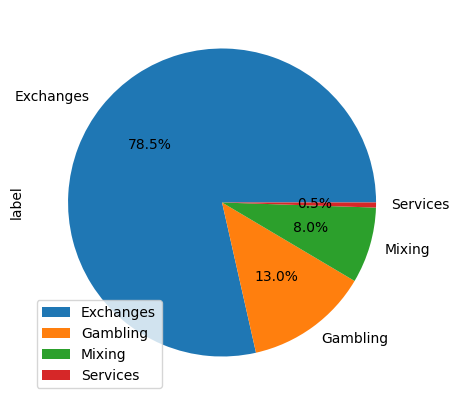

In [8]:
pf2=pd.DataFrame({'label':df['label'].value_counts().to_list()},
                    index=['Exchanges','Gambling', 'Mixing','Services'])

plt=pf2.plot.pie(y='label',autopct='%1.1f%%',figsize=(5,5))

## Random Forest Classifier


===== Evaluation Results =====
runtime_sec: 797.2748
ram_used_mb: 859.0859
accuracy: 0.9624
precision: 0.9635
recall: 0.9624
roc_auc: 0.9916
confusion_matrix:
 [[65366    33     8  1762]
 [  156   292     0     3]
 [    5     0 11073     0]
 [ 1249     4     0  5574]]


Classification Report:

              precision    recall  f1-score   support

           0       0.98      0.97      0.98     67169
           1       0.89      0.65      0.75       451
           2       1.00      1.00      1.00     11078
           3       0.76      0.82      0.79      6827

    accuracy                           0.96     85525
   macro avg       0.91      0.86      0.88     85525
weighted avg       0.96      0.96      0.96     85525



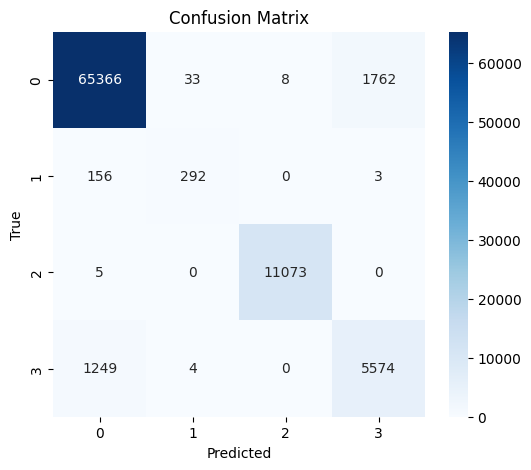

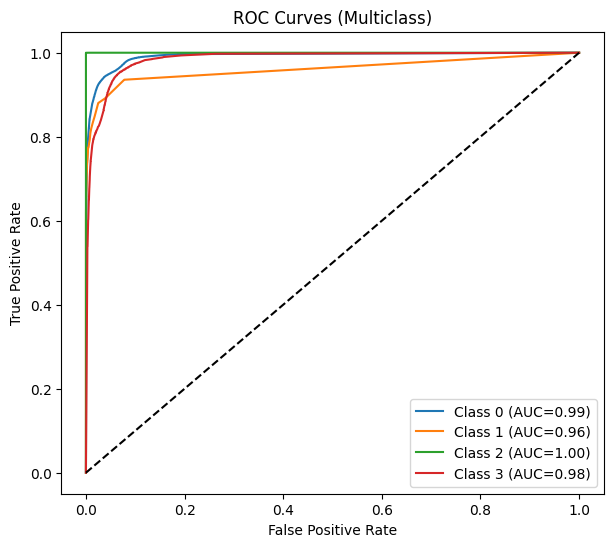

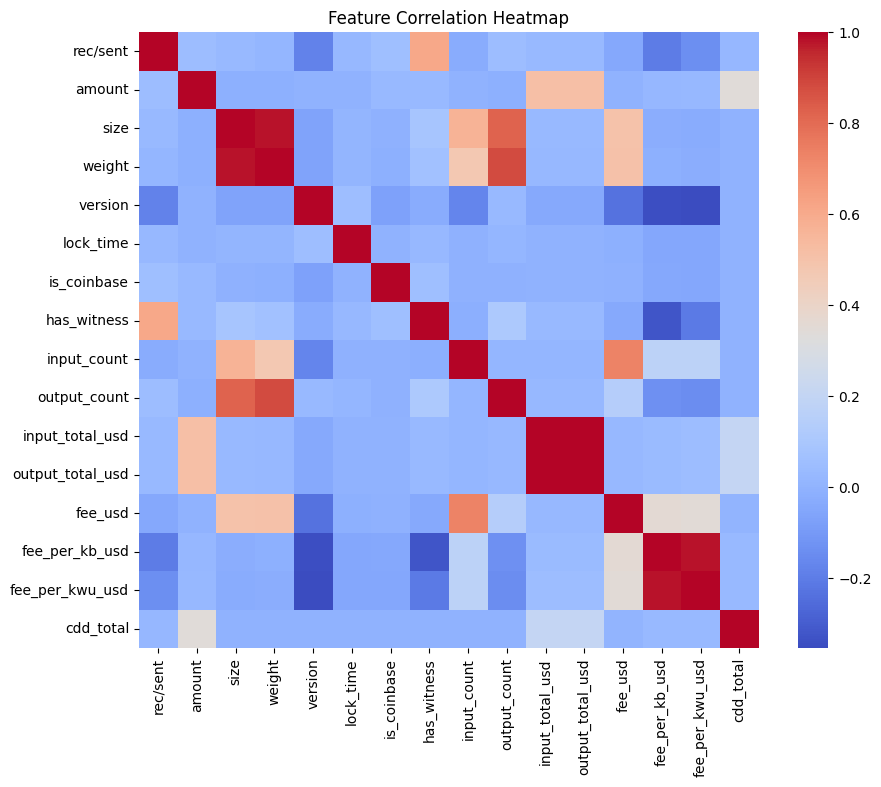

In [9]:
start_time = time()
from sklearn.ensemble import RandomForestClassifier 
model = RandomForestClassifier()  
model.fit(x_train, y_train) 

# predicting the model in testing dataset
y_pred = model.predict(x_test)

# Evaluating the model
check_prediction(y_test, y_pred, start_time, model, x_test, x_train)

In [10]:
import os
import platform

def notify_done():
    system = platform.system()
    if system == "Windows":
        import winsound
        winsound.Beep(1000, 700)   # frequency=1000 Hz, duration=700ms
    elif system == "Darwin":  # macOS
        os.system('say "Task completed"')
    else:  # Linux
        os.system('echo -e "\a"')  # terminal beep

# --- your code ---
print("Starting long process...")

# Place all your ML code here
# ...

print("Process completed!")
notify_done()

Starting long process...
Process completed!


## Bagging Classifier

Cross-validation scores: [0.97021229 0.96981942 0.96972099]
Mean CV score: 0.9699

===== Evaluation Results =====
runtime_sec: 1179.8007
ram_used_mb: 551.7930
accuracy: 0.9616
precision: 0.9629
recall: 0.9616
roc_auc: 0.9887
confusion_matrix:
 [[65295    71    11  1792]
 [  140   303     0     8]
 [    5     0 11073     0]
 [ 1249     8     0  5570]]


Classification Report:

              precision    recall  f1-score   support

           0       0.98      0.97      0.98     67169
           1       0.79      0.67      0.73       451
           2       1.00      1.00      1.00     11078
           3       0.76      0.82      0.78      6827

    accuracy                           0.96     85525
   macro avg       0.88      0.86      0.87     85525
weighted avg       0.96      0.96      0.96     85525



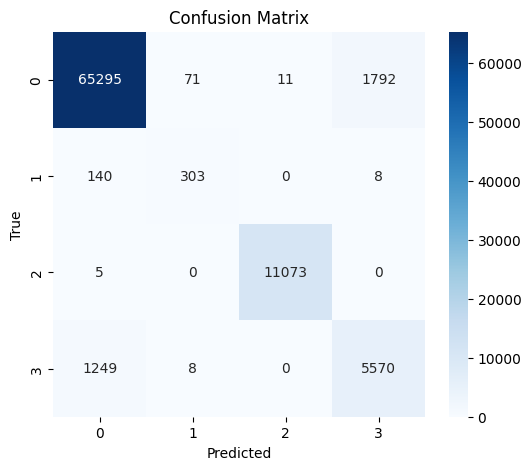

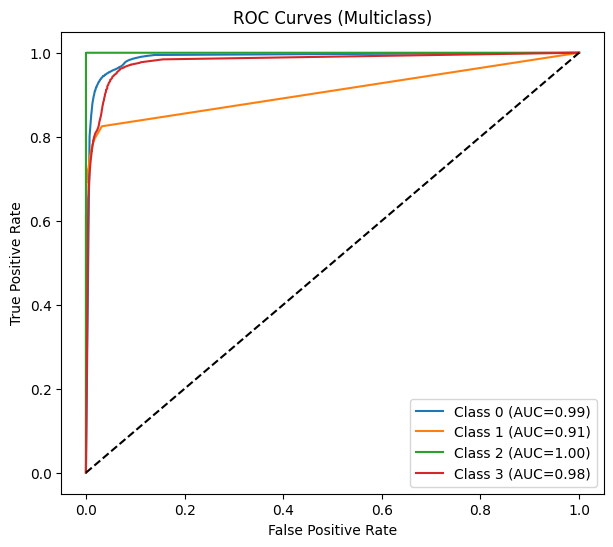

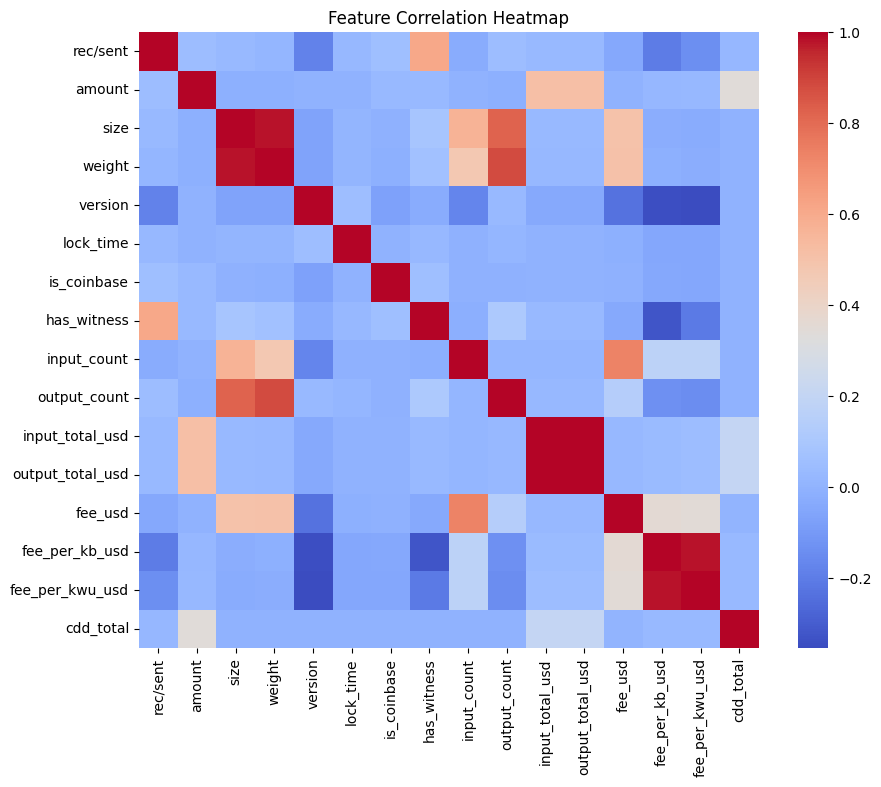

In [11]:
from time import time
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import BaggingClassifier
from sklearn.model_selection import KFold, cross_val_score

# Start timer
current_time = time()

# Initialize the base classifier
base_model = DecisionTreeClassifier()

# Number of base classifiers
n_trees = 50

# Initialize BaggingClassifier (use 'estimator' instead of 'base_estimator')
model = BaggingClassifier(
    estimator=base_model,  # updated argument name
    n_estimators=n_trees,
    random_state=50
)

# Optional: Cross-validation score
kfold = KFold(n_splits=3, shuffle=True, random_state=50)
res = cross_val_score(model, X, Y.values.ravel(), cv=kfold)
print(f"Cross-validation scores: {res}")
print(f"Mean CV score: {res.mean():.4f}")

# Train the model
model.fit(x_train, y_train.values.ravel())

# Predict
y_pred = model.predict(x_test)

# Evaluate using check_prediction
check_prediction(
    y_true=y_test,
    y_pred=y_pred,
    start_time=current_time,
    model=model,        # needed for ROC AUC
    x_test=x_test,      # needed for predict_proba
    x_train=x_train     # optional: for feature correlation heatmap
)


## XGBoost

In [4]:
!pip install xgboost


   ---------------------------------------- 0.0/56.8 MB ? eta -:--:--
   ---------------------------------------- 0.0/56.8 MB ? eta -:--:--
   ---------------------------------------- 0.1/56.8 MB 1.8 MB/s eta 0:00:32
   ---------------------------------------- 0.6/56.8 MB 6.1 MB/s eta 0:00:10
    --------------------------------------- 1.4/56.8 MB 11.1 MB/s eta 0:00:05
   - -------------------------------------- 2.5/56.8 MB 14.3 MB/s eta 0:00:04
   -- ------------------------------------- 3.4/56.8 MB 16.7 MB/s eta 0:00:04
   --- ------------------------------------ 4.4/56.8 MB 17.6 MB/s eta 0:00:03
   --- ------------------------------------ 5.4/56.8 MB 19.0 MB/s eta 0:00:03
   ---- ----------------------------------- 6.7/56.8 MB 20.3 MB/s eta 0:00:03
   ----- ---------------------------------- 7.8/56.8 MB 20.8 MB/s eta 0:00:03
   ------ --------------------------------- 9.0/56.8 MB 22.2 MB/s eta 0:00:03
   ------ --------------------------------- 9.8/56.8 MB 22.5 MB/s eta 0:00:03
   -


[notice] A new release of pip is available: 24.0 -> 25.2
[notice] To update, run: python.exe -m pip install --upgrade pip



===== Evaluation Results =====
runtime_sec: 6.6178
ram_used_mb: 506.6719
accuracy: 0.9377
precision: 0.9583
recall: 0.9377
roc_auc: 0.9934
confusion_matrix:
 [[62350   327     9  4483]
 [  115   328     0     8]
 [    4     0 11074     0]
 [  367    18     0  6442]]


Classification Report:

              precision    recall  f1-score   support

           0       0.99      0.93      0.96     67169
           1       0.49      0.73      0.58       451
           2       1.00      1.00      1.00     11078
           3       0.59      0.94      0.73      6827

    accuracy                           0.94     85525
   macro avg       0.77      0.90      0.82     85525
weighted avg       0.96      0.94      0.94     85525



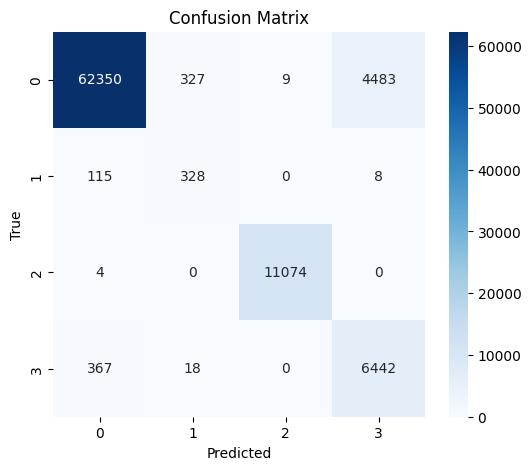

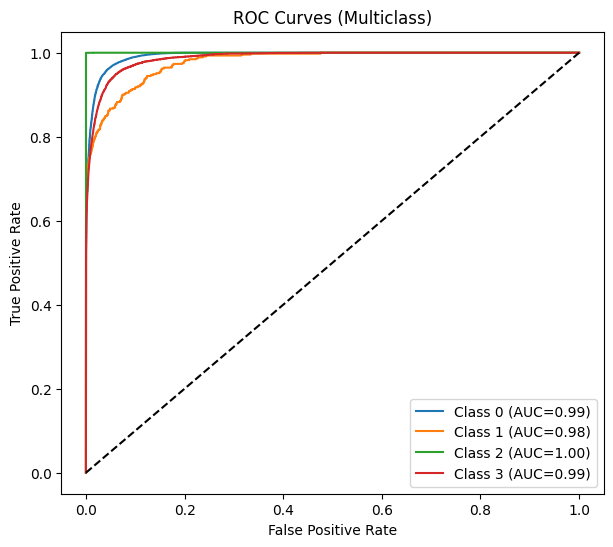

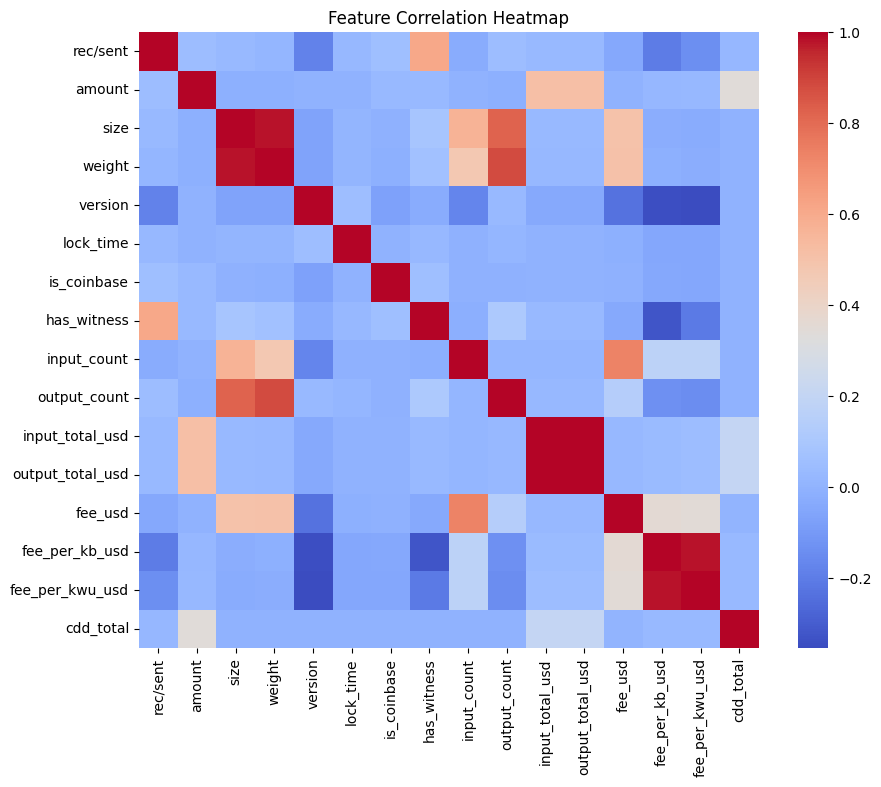

In [12]:
from time import time
from xgboost import XGBClassifier

# Start timer
current_time = time()

# Initialize the classifier
model = XGBClassifier(use_label_encoder=False, eval_metric='logloss')  # avoid warning
model.fit(x_train, y_train.values.ravel())

# Predict the test dataset
y_pred = model.predict(x_test)

# Evaluate using check_prediction
check_prediction(
    y_true=y_test,
    y_pred=y_pred,
    start_time=current_time,
    model=model,        # needed for ROC AUC
    x_test=x_test,      # needed for predict_proba
    x_train=x_train     # optional: for feature correlation heatmap
)


## Gradient Boosting


===== Evaluation Results =====
runtime_sec: 2550.3938
ram_used_mb: 180.8438
accuracy: 0.8887
precision: 0.9471
recall: 0.8887
roc_auc: 0.9874
confusion_matrix:
 [[58223  2305   154  6487]
 [   90   351     3     7]
 [    1     1 11076     0]
 [  363    99     5  6360]]


Classification Report:

              precision    recall  f1-score   support

           0       0.99      0.87      0.93     67169
           1       0.13      0.78      0.22       451
           2       0.99      1.00      0.99     11078
           3       0.49      0.93      0.65      6827

    accuracy                           0.89     85525
   macro avg       0.65      0.89      0.70     85525
weighted avg       0.95      0.89      0.91     85525



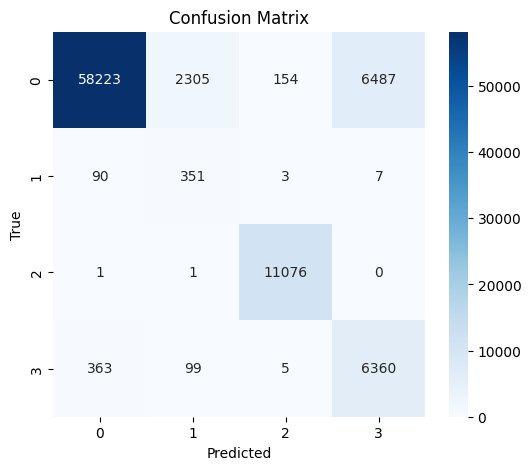

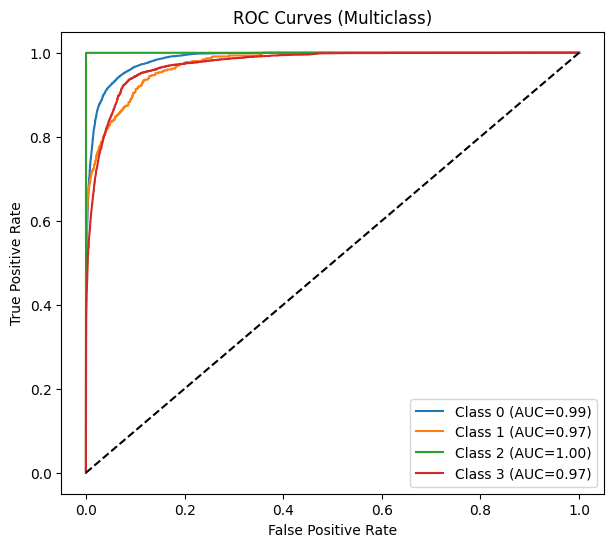

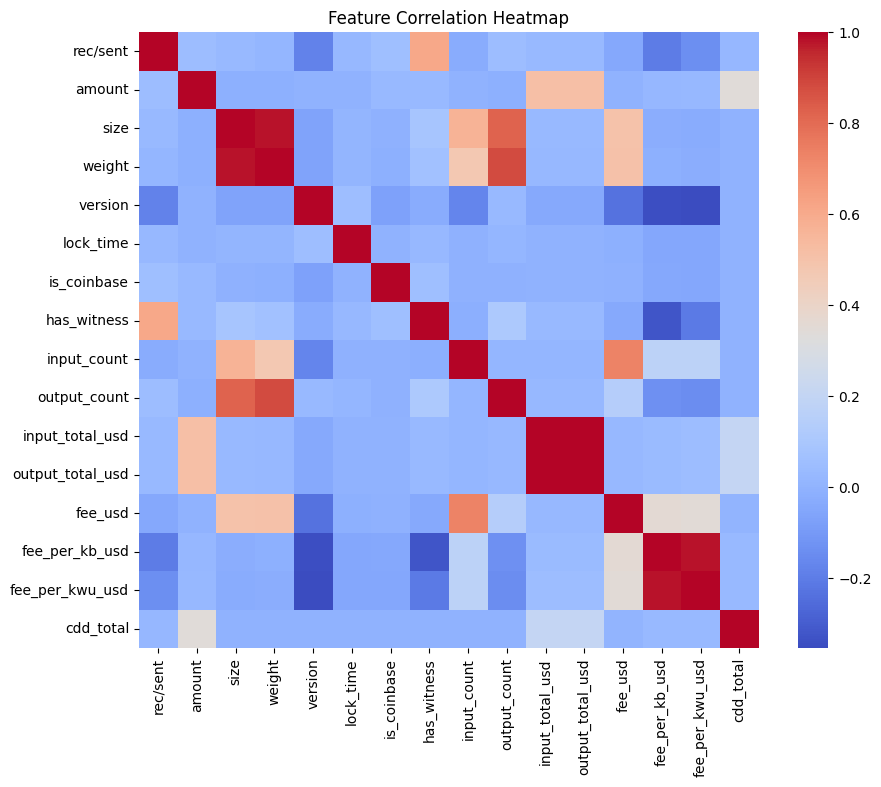

In [13]:
from time import time
from sklearn.ensemble import GradientBoostingClassifier

# Start timer
current_time = time()

# Initialize GradientBoostingClassifier
model = GradientBoostingClassifier()
model.fit(x_train, y_train.values.ravel())  # flatten to 1D if needed

# Predict test dataset
y_pred = model.predict(x_test)

# Evaluate using check_prediction
check_prediction(
    y_true=y_test,
    y_pred=y_pred,
    start_time=current_time,
    model=model,        # needed for ROC AUC
    x_test=x_test,      # needed for predict_proba
    x_train=x_train     # optional: feature correlation heatmap
)


## Extra Trees

F1-score: 0.8434357266384531

===== Evaluation Results =====
runtime_sec: 28.5432
ram_used_mb: 429.1992
accuracy: 0.8211
precision: 0.9011
recall: 0.8211
roc_auc: 0.9739
confusion_matrix:
 [[53128  2855  5498  5688]
 [   95   228    59    69]
 [    3     0 11075     0]
 [  544   196   295  5792]]


Classification Report:

              precision    recall  f1-score   support

           0       0.99      0.79      0.88     67169
           1       0.07      0.51      0.12       451
           2       0.65      1.00      0.79     11078
           3       0.50      0.85      0.63      6827

    accuracy                           0.82     85525
   macro avg       0.55      0.79      0.61     85525
weighted avg       0.90      0.82      0.84     85525



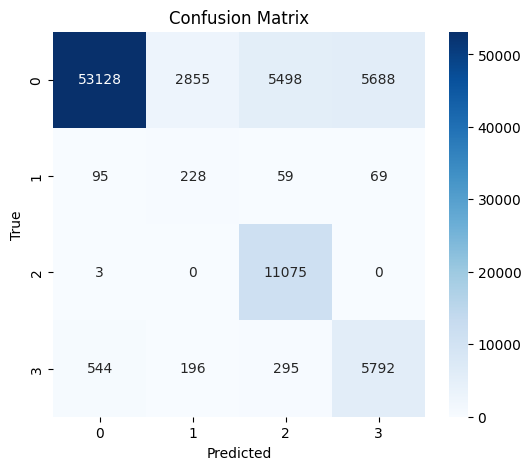

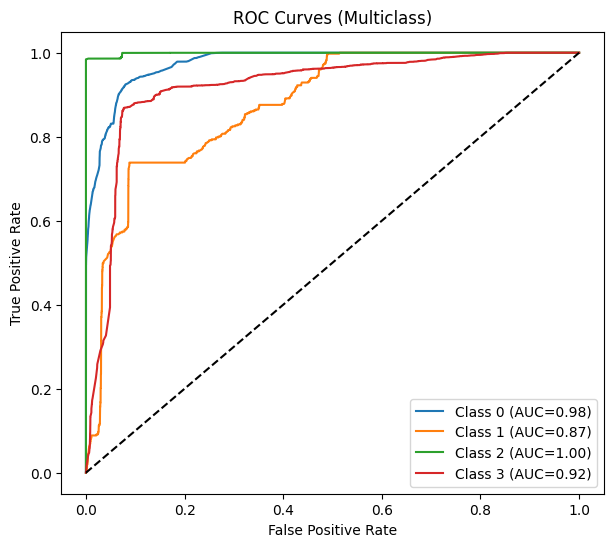

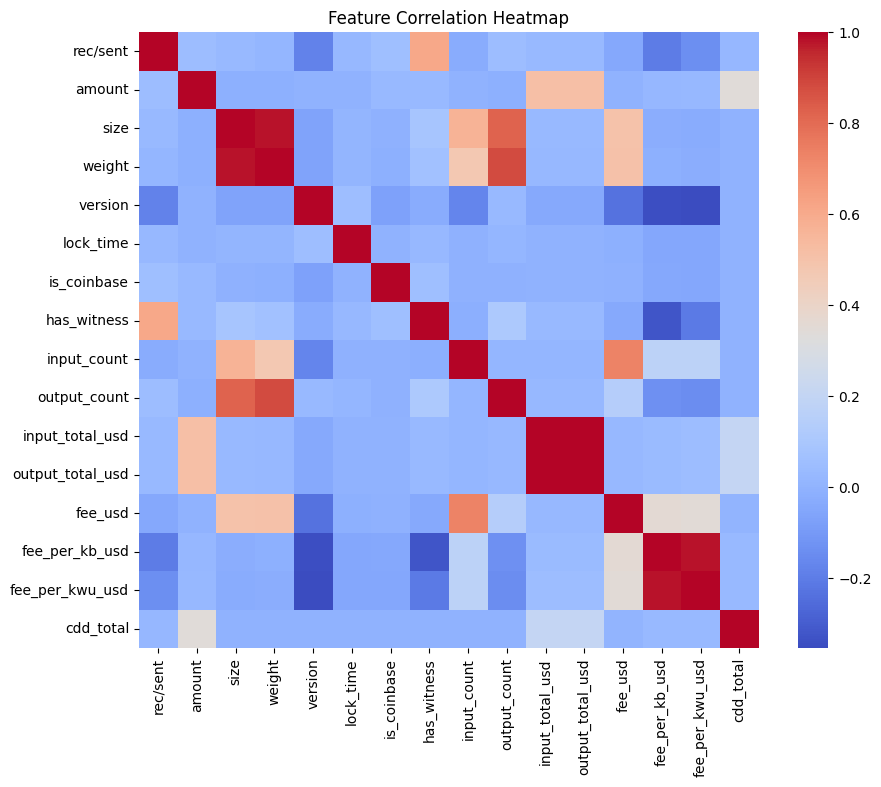

In [14]:
from time import time
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.metrics import f1_score

# Start timer
current_time = time()

# Initialize ExtraTreesClassifier
clf = ExtraTreesClassifier(
    n_estimators=100,
    max_depth=5,
    random_state=42
)

# Train the model
clf.fit(x_train, y_train.values.ravel())  # flatten to 1D

# Predict test dataset
y_pred = clf.predict(x_test)

# Evaluate F1-score
f1 = f1_score(y_test, y_pred, average='weighted')
print("F1-score:", f1)

# Evaluate with check_prediction
check_prediction(
    y_true=y_test,
    y_pred=y_pred,
    start_time=current_time,
    model=clf,        # needed for ROC AUC
    x_test=x_test,    # needed for predict_proba
    x_train=x_train   # optional: feature correlation heatmap
)


## Gaussian Naïve Bayes


===== Evaluation Results =====
runtime_sec: 0.6025
ram_used_mb: 434.6914
accuracy: 0.2072
precision: 0.8591
recall: 0.2072
roc_auc: 0.7982
confusion_matrix:
 [[16040 47522   280  3327]
 [    9   436     3     3]
 [  290 10267   507    14]
 [  186  5894     8   739]]


Classification Report:

              precision    recall  f1-score   support

           0       0.97      0.24      0.38     67169
           1       0.01      0.97      0.01       451
           2       0.64      0.05      0.09     11078
           3       0.18      0.11      0.14      6827

    accuracy                           0.21     85525
   macro avg       0.45      0.34      0.15     85525
weighted avg       0.86      0.21      0.32     85525



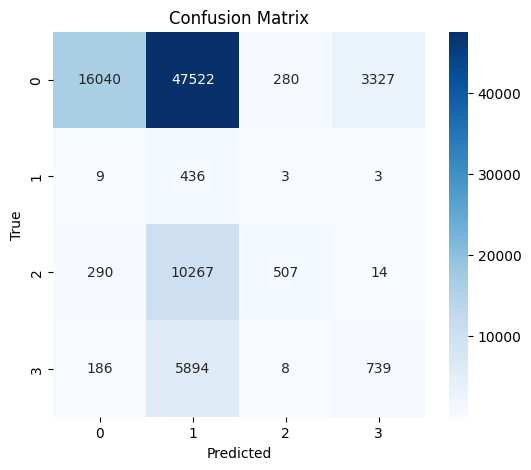

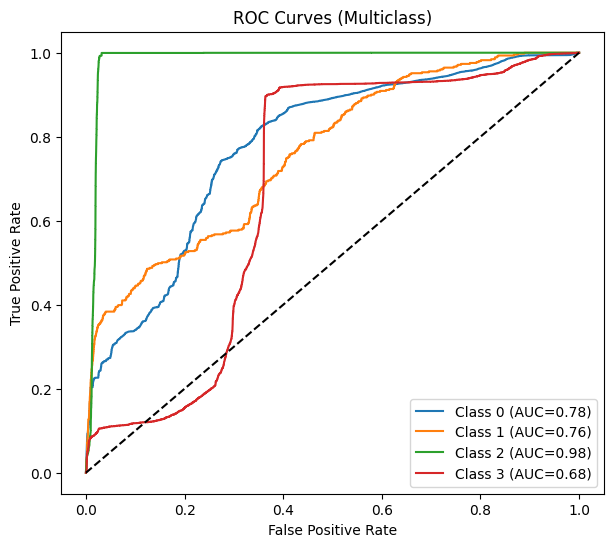

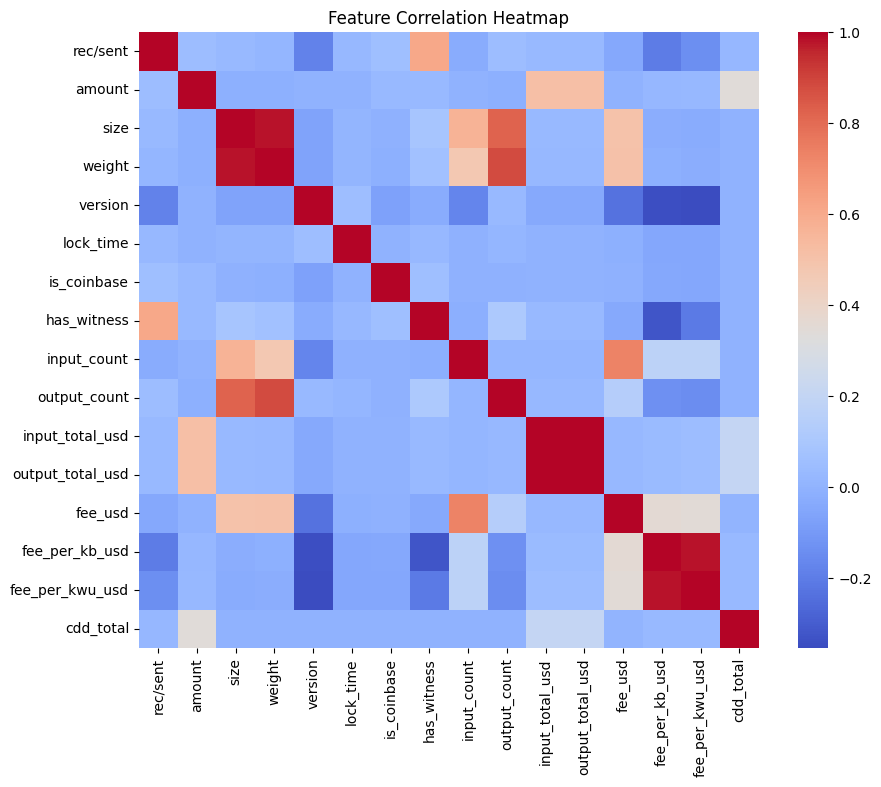

In [15]:
from time import time
from sklearn.naive_bayes import GaussianNB

# Start timer
current_time = time()

# Initialize Gaussian Naive Bayes
model = GaussianNB()

# Train the model
model.fit(x_train, y_train.values.ravel())  # flatten to 1D

# Predict test dataset
y_pred = model.predict(x_test)

# Evaluate using check_prediction
check_prediction(
    y_true=y_test,
    y_pred=y_pred,
    start_time=current_time,
    model=model,        # needed for ROC AUC
    x_test=x_test,      # needed for predict_proba
    x_train=x_train     # optional: feature correlation heatmap
)


## Classification and Regression Trees (CART)


===== Evaluation Results =====
runtime_sec: 6.8900
ram_used_mb: 439.6680
accuracy: 0.7419
precision: 0.9117
recall: 0.7419
roc_auc: 0.9216
confusion_matrix:
 [[46486  5280  1613 13790]
 [   70   283    24    74]
 [    1    10 10988    79]
 [  440   549   142  5696]]


Classification Report:

              precision    recall  f1-score   support

           0       0.99      0.69      0.81     67169
           1       0.05      0.63      0.09       451
           2       0.86      0.99      0.92     11078
           3       0.29      0.83      0.43      6827

    accuracy                           0.74     85525
   macro avg       0.55      0.79      0.56     85525
weighted avg       0.91      0.74      0.79     85525



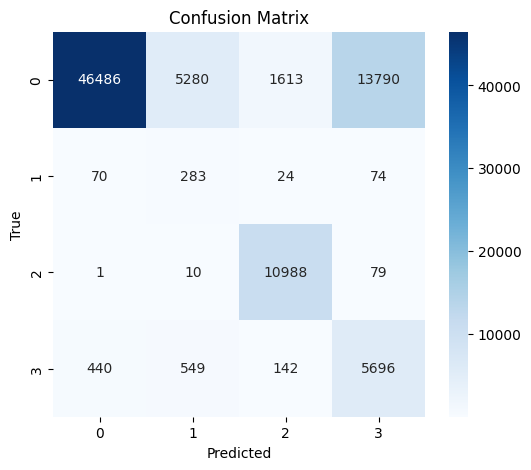

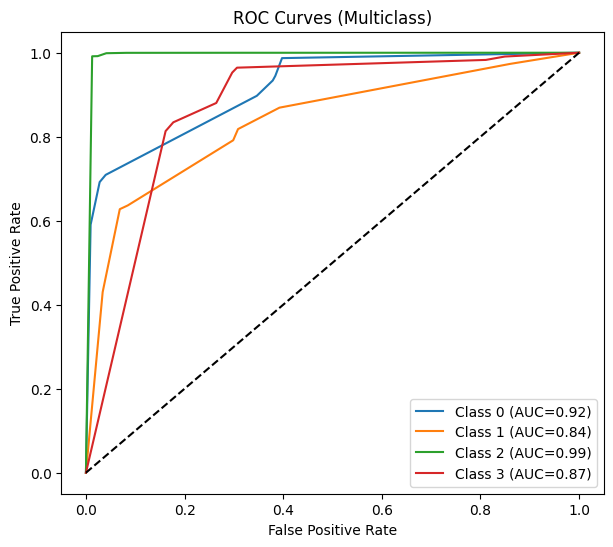

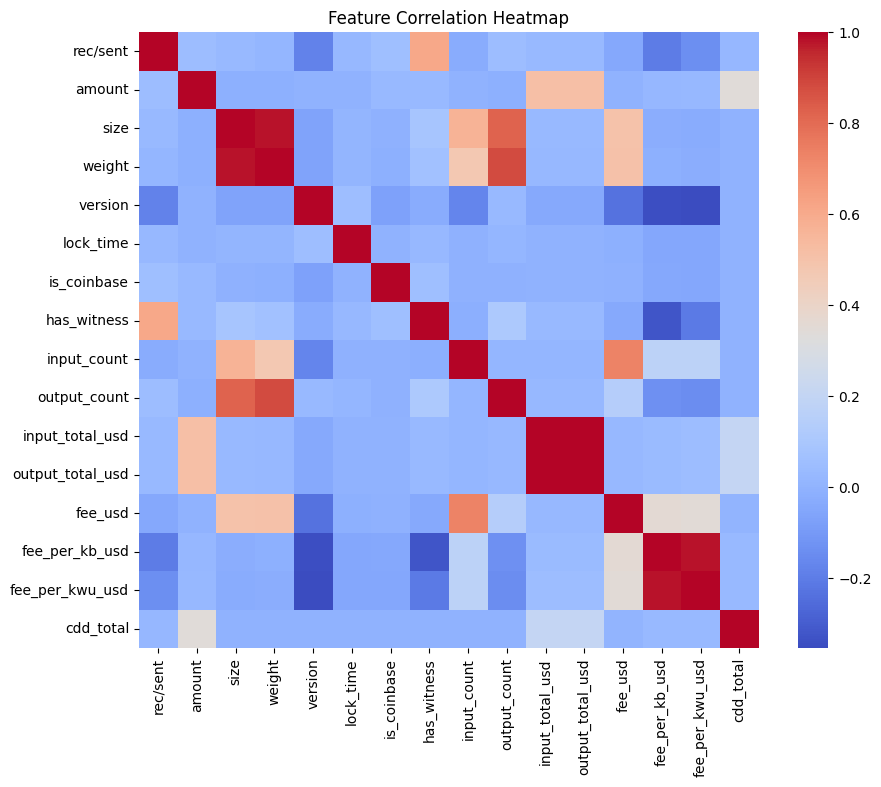

In [16]:
from time import time
from sklearn.tree import DecisionTreeClassifier

# Start timer
current_time = time()

# Create Decision Tree classifier
clf = DecisionTreeClassifier(max_depth=3)

# Fit the model
clf.fit(x_train, y_train.values.ravel())  # flatten to 1D

# Make predictions on test data
y_pred = clf.predict(x_test)

# Evaluate using check_prediction
check_prediction(
    y_true=y_test,
    y_pred=y_pred,
    start_time=current_time,
    model=clf,        # needed for ROC AUC
    x_test=x_test,    # needed for predict_proba
    x_train=x_train   # optional: feature correlation heatmap
)


## K-Nearest Neighbours


===== Evaluation Results =====
runtime_sec: 156.2112
ram_used_mb: 586.3164
accuracy: 0.9502
precision: 0.9583
recall: 0.9502
roc_auc: 0.9694
confusion_matrix:
 [[64112   573    14  2470]
 [  142   298     3     8]
 [    6     0 11071     1]
 [ 1020    20     1  5786]]


Classification Report:

              precision    recall  f1-score   support

           0       0.98      0.95      0.97     67169
           1       0.33      0.66      0.44       451
           2       1.00      1.00      1.00     11078
           3       0.70      0.85      0.77      6827

    accuracy                           0.95     85525
   macro avg       0.75      0.87      0.79     85525
weighted avg       0.96      0.95      0.95     85525



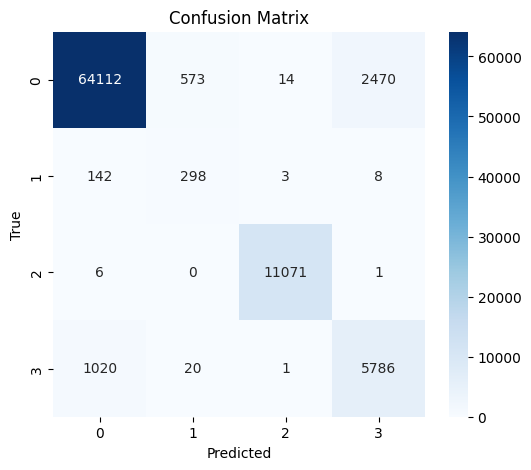

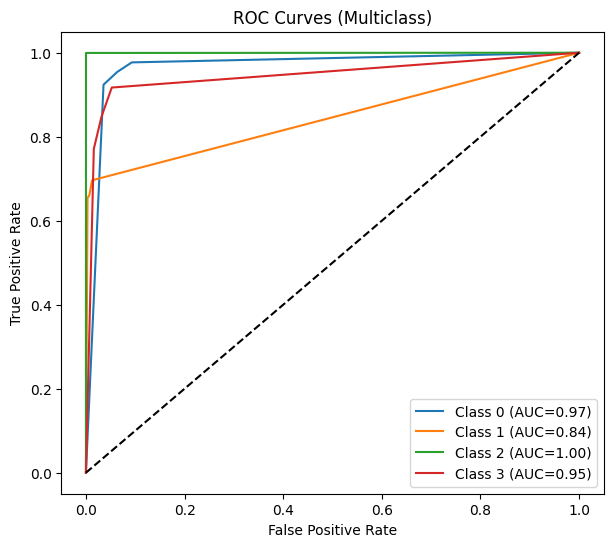

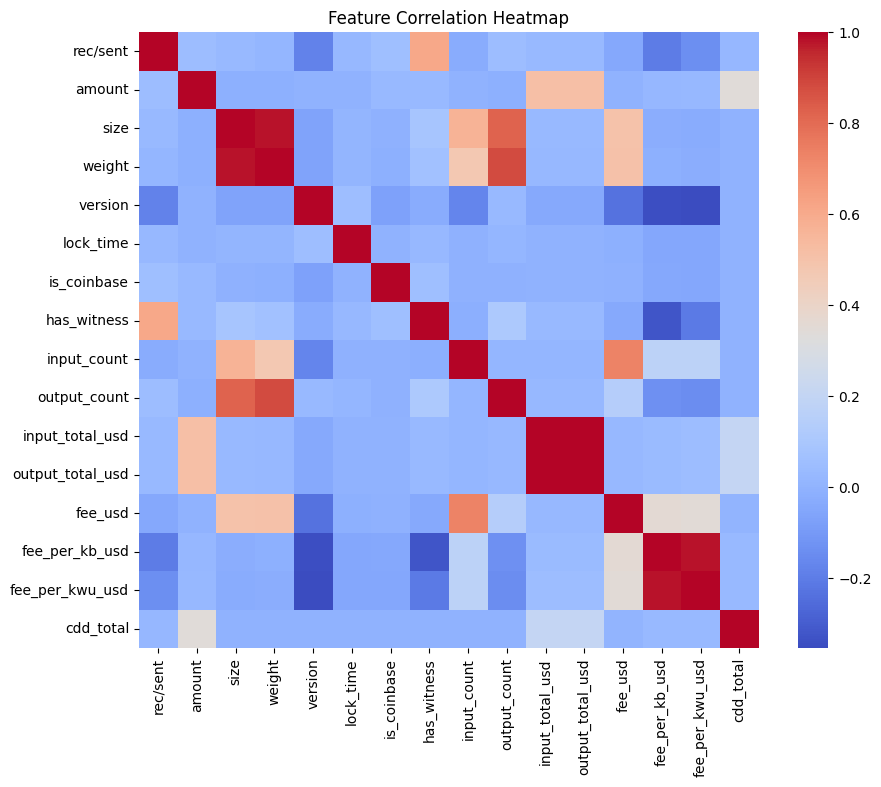

In [17]:
from time import time
from sklearn.neighbors import KNeighborsClassifier

# Start timer
current_time = time()

# Initialize KNN classifier
knn = KNeighborsClassifier(n_neighbors=3)

# Train the model
knn.fit(x_train, y_train.values.ravel())  # flatten to 1D

# Predict the test dataset
y_pred = knn.predict(x_test)

# Evaluate using check_prediction
check_prediction(
    y_true=y_test,
    y_pred=y_pred,
    start_time=current_time,
    model=knn,        # needed for ROC AUC
    x_test=x_test,    # needed for predict_proba
    x_train=x_train   # optional: feature correlation heatmap
)


##  Adaboost


===== Evaluation Results =====
runtime_sec: 121.4363
ram_used_mb: 575.6914
accuracy: 0.7910
precision: 0.9181
recall: 0.7910
roc_auc: 0.9342
confusion_matrix:
 [[50546  5120  1262 10241]
 [   87   331    17    16]
 [    3    12 11063     0]
 [  656   385    80  5706]]


Classification Report:

              precision    recall  f1-score   support

           0       0.99      0.75      0.85     67169
           1       0.06      0.73      0.11       451
           2       0.89      1.00      0.94     11078
           3       0.36      0.84      0.50      6827

    accuracy                           0.79     85525
   macro avg       0.57      0.83      0.60     85525
weighted avg       0.92      0.79      0.83     85525



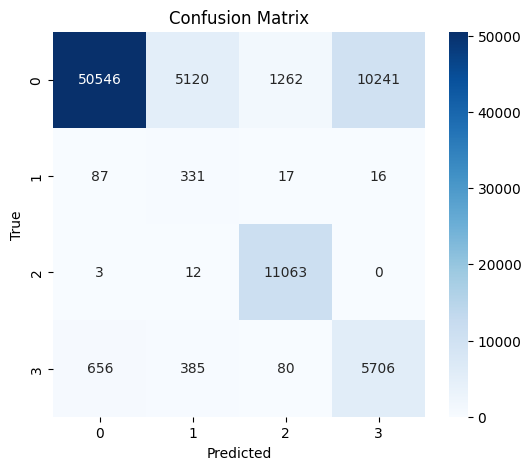

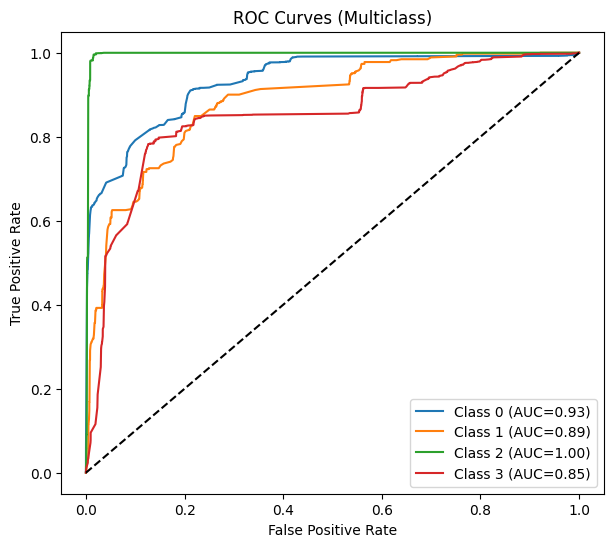

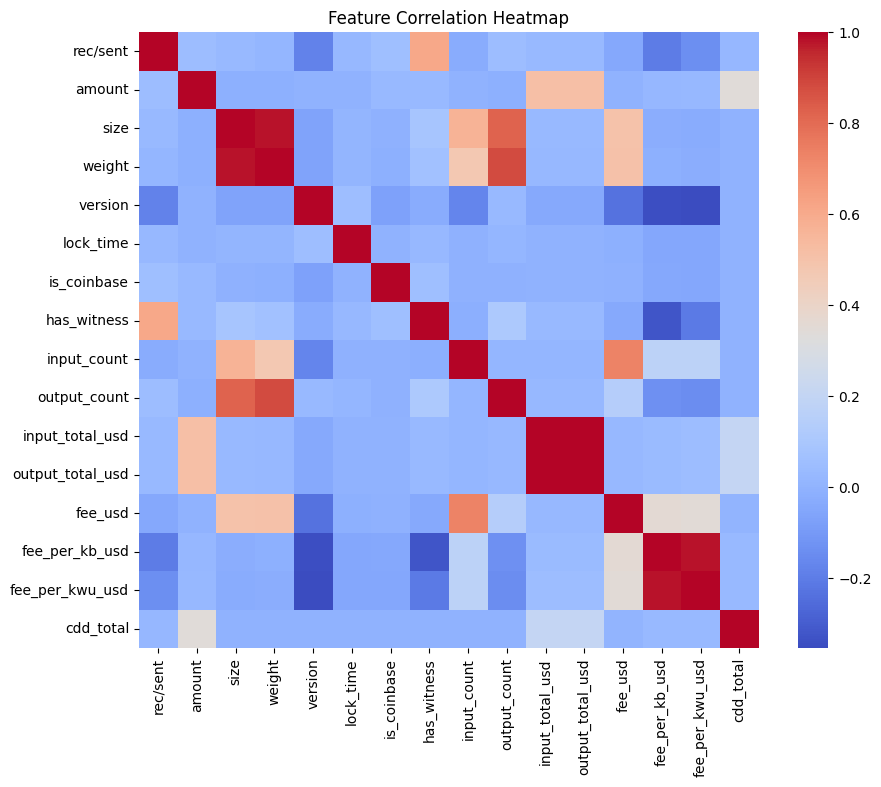

In [18]:
from time import time
from sklearn.ensemble import AdaBoostClassifier

# Start timer
current_time = time()

# Initialize AdaBoost classifier
adboost = AdaBoostClassifier()
adboost.fit(x_train, y_train.values.ravel())  # flatten to 1D

# Predict the test dataset
y_pred = adboost.predict(x_test)

# Evaluate using check_prediction
check_prediction(
    y_true=y_test,
    y_pred=y_pred,
    start_time=current_time,
    model=adboost,    # needed for ROC AUC
    x_test=x_test,    # needed for predict_proba
    x_train=x_train   # optional: feature correlation heatmap
)


In [19]:
import os
import platform

def notify_done():
    system = platform.system()
    if system == "Windows":
        import winsound
        winsound.Beep(1000, 700)   # frequency=1000 Hz, duration=700ms
    elif system == "Darwin":  # macOS
        os.system('say "Task completed"')
    else:  # Linux
        os.system('echo -e "\a"')  # terminal beep

# --- your code ---
print("Starting long process...")

# Place all your ML code here
# ...

print("Process completed!")
notify_done()


Starting long process...
Process completed!
